## Retention

In [4]:
import pandas as pd
from retention_game import retention_game

import seaborn as sns
import matplotlib.pylab as plt

import requests
from urllib.parse import urlencode

### Задание 1
#### Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать #### retention игроков (по дням от даты регистрации игрока).

In [ ]:
# создадим функцию для получения url загрузки и загрузим данные

In [5]:
def get_url (public_key):
    """"Чтобы получить URL для непосредственной загрузки файла, необходимо передать путь на Яндекс Диске,
    по которому загруженный файл должен быть доступен"""
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    download_url = response.json()['href']
    return download_url

In [6]:
# загружаем данные и проводим осмотр
reg = pd.read_csv(get_url('https://disk.yandex.ru/d/y8Jarq4NzE4naw'), sep = ';')
auth = pd.read_csv(get_url('https://disk.yandex.ru/d/VBPzZH9-K5LieA'), sep = ';')

In [7]:
auth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9601013 entries, 0 to 9601012
Data columns (total 2 columns):
 #   Column   Dtype
---  ------   -----
 0   auth_ts  int64
 1   uid      int64
dtypes: int64(2)
memory usage: 146.5 MB


In [8]:
auth.head(1)

,auth_ts,uid
0,911382223,1


In [9]:
reg.head(1)

,reg_ts,uid
0,911382223,1


In [10]:
# Переводим столбец из unit time в формат "YYYY-MM-DD" 
reg.reg_ts = pd.to_datetime(reg.reg_ts, unit='s')
reg.reg_ts = reg.reg_ts.dt.normalize()

In [11]:
# Объеденяем два датасета
auth_reg = auth.merge(reg, on = 'uid', how = 'left')

In [12]:
# Переводим столбец из unit time в формат "YYYY-MM-DD"
auth_reg.auth_ts = pd.to_datetime(auth_reg.auth_ts, unit='s')
auth_reg.auth_ts = auth_reg.auth_ts.dt.normalize()

In [13]:
# Создаем столбец с информаей о разнице ней между регистрацией и авторизацией
auth_reg['diff'] = auth_reg['auth_ts'] - auth_reg['reg_ts'] 

In [14]:
# Создаем датасет где индексы - даты регистрации, столбцы - количество дней с регистрации до авторизации
pivot = auth_reg \
    .groupby(['reg_ts','diff'], as_index = False) \
    .agg({'uid':'nunique'}) \
    .pivot(index='reg_ts', columns='diff', values='uid')

In [15]:
# Высчитываем Retention в процентах и округляем до 1 значения после запятой
retention = pivot.divide(pivot['0 days'],axis=0).mul(100).fillna(0).round(1)

In [16]:
retention.head()

diff,0 days,1 days,2 days,3 days,4 days,5 days,6 days,7 days,8 days,9 days,...,7701 days,7704 days,7706 days,7709 days,7712 days,7716 days,7720 days,7721 days,7727 days,7729 days
reg_ts,,,,,,,,,,,,,,,,,,,,,
1998-11-18,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1999-07-22,100.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,100.0,...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
2000-01-13,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-05-28,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-09-16,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
# Пишем функцию в отдельном файле для опредления retention  игроков по дням от даты регистрации.
# Когорты - дни регистрации. 
# Импортируем функцию в наш ноутбук (в начале)

In [18]:
# посмотрим документацию функции
help(retention_game)

Help on function retention_game in module retention_game:

retention_game(df_reg, df_auth, date_reg_1, date_reg_2, ret_1, ret_2)
    " Возвращает retention заданых дней, для заданных когорт ( Когорты определены по дню регистрации).
    :param df_reg: Датасет с информацией о регистрации пользователей
    :type df_reg: columns [reg_ts] в формате unix time - int и [uid] - id  пользователя в int
    :param df_auth: Датасет с информацией о авторизациях пользователей
    :type df_reg: columns [auth_ts] в формате unix time - int и [uid] - id  пользователя в int
    :param date_reg_1: Дата первой когорты, из промежутка который нас интересуте
    :type date_reg_1: Формат ввода: "YYYY-MM-DD" str   
    :param date_reg_2: Дата последней когорты, из промежутка который нас интересуте
    :type date_reg_2: Формат ввода: "YYYY-MM-DD" str
    :param ret_1: Указать Retention какого дня нас интересует
            ( если только за один день, то продублировать значение в ret_2, если инетересует интервал т

In [ ]:
# посмотрим retention по заданным датам
df = retention_game(reg, auth, '2020-08-01', '2020-08-16', 1, 10)
df

Text(159.0, 0.5, 'Registration date')

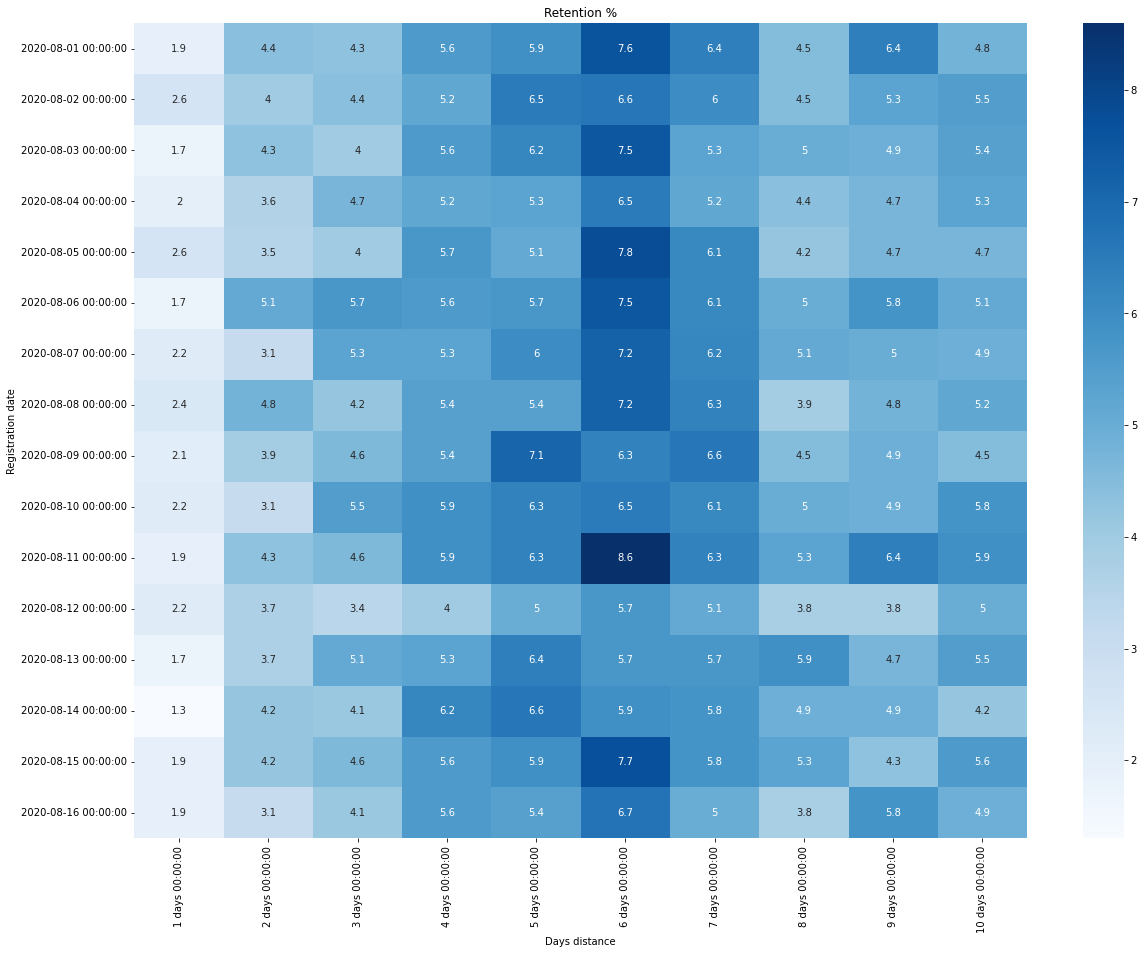

In [16]:
# Визуализируем через heatmap наш полученный датасет
plt.figure(figsize=(20,15))
plt.title('Retention %')
ax = sns.heatmap(data=df, annot=True, cmap='Blues')
ax.set_yticklabels(df.index)
ax.set_xticklabels(df.columns)
plt.xlabel('Days distance')
plt.ylabel('Registration date')